In [1]:
!pip install konlpy
from konlpy.tag import Komoran
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

In [2]:
%matplotlib inline
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(515)

In [3]:
print(device)

cuda


In [4]:
!git clone https://github.com/choi-hyunkyu/data.git
tokenizer = Komoran()
original_data_df = pd.read_csv('./data/data/chatbot_data_old.csv')

fatal: destination path 'data' already exists and is not an empty directory.


In [5]:
original_data_df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [6]:
original_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


In [7]:
original_data_df.isnull().sum()

Q        0
A        0
label    0
dtype: int64

In [8]:
shuffled_data_df = original_data_df.sample(frac=1).reset_index(drop=True)

In [9]:
question = shuffled_data_df.drop(['A'], axis = 1)
answer = shuffled_data_df.drop(['Q', 'label'], axis = 1)

In [10]:
question.head()

,Q,label
0,삼겹살에 소주,0
1,썸인데 싸늘해,2
2,아무리 매달려도,1
3,눈이 피곤해,0
4,재회 어떻하죠?,1


In [11]:
answer.head()

,A
0,생각만 해도 군침이 도네요.
1,고백할 타이밍이 너무 늦지 않았는지 생각해보세요.
2,돌아서지 않을 수 있어요.
3,눈 체조를 해보세요.
4,조심스레 연락을 해보는 것도 좋을 것 같아요.


In [12]:
question_list = question['Q'].tolist()
question_label = question['label'].tolist()

answer_list = answer['A'].tolist()

In [13]:
# preprocessing
def vocab(text_list):
    token = tokenizing(text_list)
    words = uniquewords(token)
    output = word2index(words)
    output['<PAD>'] = 0
    output['<OOV>'] = 1
    return output

def word2index(unique_word_list):
    return {value: index+2 for index, value in enumerate(unique_word_list)}

def uniquewords(word_list):
    return list(set([i for value in word_list for i in value]))

def tokenizing(text_list):
    return [tokenizer.morphs(normalizeString(sentence)) for sentence in text_list]

def normalizeString(text_list):
    return re.compile('[^ ㄱ-ㅣ가-힣 ^☆; ^a-zA-Z.!?;0-9]+').sub('', text_list)

In [14]:
# utils
def train(model, criterion, optimizer, nb_epochs, 
          input_size, train_dataloader, validation_dataloader):
    
    # Train loop
    trn_loss_list = []
    val_loss_list = []
    for epoch in range(nb_epochs):

        # Train
        trn_loss = 0.0
        for trn_batch, train_samples in enumerate(train_dataloader):

            # train data setting
            x_train, y_train = train_samples
            x_train = x_train.unsqueeze(0).to(device)
            y_train = y_train.view(-1).long().to(device)

            # train
            model.train()
            hypothesis = model(x_train).view(-1, hidden_size)
            optimizer.zero_grad()
            train_loss = criterion(hypothesis, y_train)
            train_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            optimizer.step()

            # train loss
            trn_loss += train_loss.item() / len(train_dataloader)
        trn_loss_list.append(trn_loss)

        # Evaluation
        with torch.no_grad():
            val_loss = 0.0
            for val_batch, validation_samples in enumerate(validation_dataloader):

                # validatoin data setting
                x_validation, y_validation = validation_samples
                x_validation = x_validation.unsqueeze(0).to(device)
                y_validation = y_validation.view(-1).long().to(device)

                # evaluation
                model.eval()
                prediction = model(x_validation).view(-1, hidden_size)
                validation_loss = criterion(prediction, y_validation)

                # validation loss
                val_loss += validation_loss.item() / len(validation_dataloader)
            val_loss_list.append(val_loss)

        print("Epoch: {:3d} | Train Loss: {:.6f} | Val Loss: {:.6f}".format(epoch + 1, trn_loss, val_loss))
    #torch.save(model, './data/temperature_model.pt')
    return trn_loss_list, val_loss_list

def checkdata(dataloader):
    for index, value in enumerate(dataloader):
        while index < 6:
            x, y = value
            print("{} Batch".format(index))
            print("Input: {}".format(x.shape))
            print("Target: {}".format(y.shape))
            break

def checkfunction(dataloader, num):
    for batch, value in enumerate(dataloader):
      x_, y_ = value
      print(batch)
      x_ = x_.unsqueeze(0).to(device)
      print(x_.size())
      hypothesis = model(x_).view(-1, hidden_size)
      print(hypothesis.size())
      y_ = y_.view(-1).long().to(device)
      print(y_.size())
      loss = criterion(hypothesis, y_)
      print(loss)
      print()
      if batch == num:
        break

def SplitData(encoded_q, encoded_a, question_label):
    total_size = len(encoded_q)

    train_input_data = encoded_q[0:int(total_size * 0.7)]
    train_target_data = question_label[0:int(total_size * 0.7)]

    validation_input_data = encoded_q[int(total_size * 0.7):]
    validation_target_data = question_label[int(total_size * 0.7):]

    test_input_data = encoded_a
    test_target_data = None
    
    return (train_input_data, 
            train_target_data, 
            validation_input_data, 
            validation_target_data, 
            test_input_data)

def MakeDataset(input_data, target_data):
    dataset_size = len(input_data)
    input_ts = torch.FloatTensor(np.array(input_data))
    target_ts = torch.FloatTensor(np.array(target_data)).view(-1, 1)
    dataset = data.TensorDataset(input_ts, target_ts)
    return dataset, dataset_size

def MakeDataLoader(dataset, batch_size):
    return data.DataLoader(dataset, batch_size = batch_size, shuffle = True, drop_last = True)

def integerEncoding(tokenized_data, vocab):
    encoded = []
    for line in tokenized_data:
        temp = []
        for w in line:
            try:
                temp.append(vocab[w])
            except KeyError:
                temp.append(vocab['<OOV>'])
        encoded.append(temp)
    return encoded

def visualizing_length(encoded):
    max_len = max(len(l) for l in encoded)
    print('최대 길이 : %d' % max_len)
    print('최소 길이 : %d' % min(len(l) for l in encoded))
    print('평균 길이 : %f' % (sum(map(len, encoded))/len(encoded)))
    plt.hist([len(s) for s in encoded], bins=50)
    plt.xlabel('length of sample')
    plt.ylabel('number of sample')
    plt.show()
    
def padding(encoded, vocab, max_length):
    for line in encoded:
        if len(line) < max_length:
            line += [vocab['<PAD>']] * (max_length - len(line))

In [15]:
tokenized_q = tokenizing(question_list)
tokenized_a = tokenizing(answer_list)
words_q = vocab(question_list)
words_a = vocab(answer_list)

In [16]:
encoded_q = integerEncoding(tokenized_q, words_q)
encoded_a = integerEncoding(tokenized_a, words_a)

In [17]:
print(encoded_q[:3])
print(encoded_a[:3])

[[3996, 2498, 1010], [4338, 2268, 3518, 4036], [3131, 2163, 964]]
[[376, 1433, 2537, 2563, 2216, 2172, 2319, 322, 1477], [241, 2537, 3216, 247, 2172, 2033, 2842, 451, 3013, 2784, 1834, 376, 2537, 2903, 446, 561, 1694, 1477], [2055, 451, 3013, 3130, 223, 3005, 1694, 1477]]


최대 길이 : 30
최소 길이 : 1
평균 길이 : 7.603992


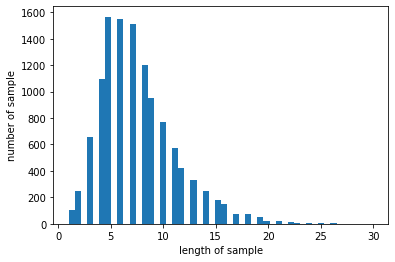

최대 길이 : 44
최소 길이 : 1
평균 길이 : 9.484141


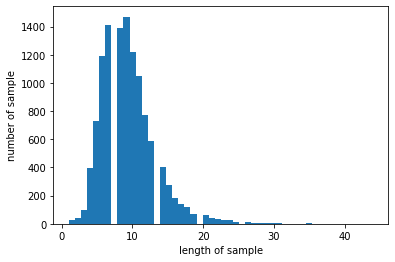

In [18]:
visualizing_length(encoded_q)
visualizing_length(encoded_a)

In [19]:
max_length_q, max_length_a = 30, 30

padding(encoded_q, words_q, max_length_q)
padding(encoded_a, words_a, max_length_a)

In [20]:
print(encoded_q[:3])
print(encoded_a[:3])

[[3996, 2498, 1010, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [4338, 2268, 3518, 4036, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [3131, 2163, 964, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[376, 1433, 2537, 2563, 2216, 2172, 2319, 322, 1477, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [241, 2537, 3216, 247, 2172, 2033, 2842, 451, 3013, 2784, 1834, 376, 2537, 2903, 446, 561, 1694, 1477, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2055, 451, 3013, 3130, 223, 3005, 1694, 1477, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [21]:
# model
class BILSTM(nn.Module):
    def __init__(self, input_size, batch_size, hidden_size, num_layers, vocab_size, embedding_dim, dropout_p = 0.2):
        super(BILSTM, self).__init__()
        
        self.input_size = input_size
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.lstm = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            dropout = 0.3,
            #batch_first = True,
            bidirectional = True)
        self.fc = nn.Linear(
            in_features = self.hidden_size * 2, 
            out_features = self.hidden_size, 
            bias = True)
        nn.init.xavier_uniform_(self.fc.weight)
        
    def forward(self, x):
        # init hidden and cell state
        h_0 = torch.zeros(self.num_layers * 2, self.batch_size, self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers * 2, self.batch_size, self.hidden_size).to(device)
        # forward pass
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out)        
        return out

In [22]:
batch_size = 128
input_size = 30
num_layers = 1
num_vocab = len(words_q)
embedding_dim = 256
hidden_size = 512
learning_rate = 1e-5
max_norm = 5 # gradient clipping
nb_epochs = 200

In [23]:
trn_input, trn_target, val_input, val_target, test_input_data = SplitData(encoded_q, encoded_a, question_label)

In [24]:
trn_dataset, trn_dataset_size = MakeDataset(trn_input, trn_target)
trn_dataloader = MakeDataLoader(trn_dataset, batch_size)

val_dataset, val_dataset_size = MakeDataset(val_input, val_target)
val_dataloader = MakeDataLoader(val_dataset, batch_size)

In [25]:
print(checkdata(trn_dataloader))
print(checkdata(val_dataloader))

0 Batch
Input: torch.Size([128, 30])
Target: torch.Size([128, 1])
1 Batch
Input: torch.Size([128, 30])
Target: torch.Size([128, 1])
2 Batch
Input: torch.Size([128, 30])
Target: torch.Size([128, 1])
3 Batch
Input: torch.Size([128, 30])
Target: torch.Size([128, 1])
4 Batch
Input: torch.Size([128, 30])
Target: torch.Size([128, 1])
5 Batch
Input: torch.Size([128, 30])
Target: torch.Size([128, 1])
None
0 Batch
Input: torch.Size([128, 30])
Target: torch.Size([128, 1])
1 Batch
Input: torch.Size([128, 30])
Target: torch.Size([128, 1])
2 Batch
Input: torch.Size([128, 30])
Target: torch.Size([128, 1])
3 Batch
Input: torch.Size([128, 30])
Target: torch.Size([128, 1])
4 Batch
Input: torch.Size([128, 30])
Target: torch.Size([128, 1])
5 Batch
Input: torch.Size([128, 30])
Target: torch.Size([128, 1])
None


In [26]:
model = BILSTM(input_size, batch_size, hidden_size, num_layers, num_vocab, embedding_dim).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [27]:
print(model)
print(criterion)
print(optimizer)
print(checkfunction(trn_dataloader, 5))

BILSTM(
  (embedding): Embedding(4473, 256)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(30, 512, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=1024, out_features=512, bias=True)
)
CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0
)
0
torch.Size([1, 128, 30])
torch.Size([128, 512])
torch.Size([128])
tensor(6.3845, device='cuda:0', grad_fn=<NllLossBackward>)

1
torch.Size([1, 128, 30])
torch.Size([128, 512])
torch.Size([128])
tensor(6.3766, device='cuda:0', grad_fn=<NllLossBackward>)

2
torch.Size([1, 128, 30])
torch.Size([128, 512])
torch.Size([128])
tensor(6.3802, device='cuda:0', grad_fn=<NllLossBackward>)

3
torch.Size([1, 128, 30])
torch.Size([128, 512])
torch.Size([128])
tensor(6.3830, device='cuda:0', grad_fn=<NllLossBackward>)

4
torch.Size([1, 128, 30])
torch.Size([128, 512])
torch.Size([128])
tensor(6.3643, device='cuda:0', grad_fn=<NllLossBackward>)

5
torch.Size([

In [28]:
trn_loss, val_loss = train(model, criterion, optimizer, nb_epochs, 
                           input_size, trn_dataloader, val_dataloader)

Epoch:   1 | Train Loss: 6.226937 | Val Loss: 6.097063
Epoch:   2 | Train Loss: 5.926917 | Val Loss: 5.809445
Epoch:   3 | Train Loss: 5.632356 | Val Loss: 5.514153
Epoch:   4 | Train Loss: 5.334428 | Val Loss: 5.219229
Epoch:   5 | Train Loss: 5.032116 | Val Loss: 4.914328
Epoch:   6 | Train Loss: 4.727384 | Val Loss: 4.604802
Epoch:   7 | Train Loss: 4.413213 | Val Loss: 4.289994
Epoch:   8 | Train Loss: 4.096312 | Val Loss: 3.970514
Epoch:   9 | Train Loss: 3.775398 | Val Loss: 3.651414
Epoch:  10 | Train Loss: 3.452675 | Val Loss: 3.329805
Epoch:  11 | Train Loss: 3.133309 | Val Loss: 3.017272
Epoch:  12 | Train Loss: 2.833383 | Val Loss: 2.726985
Epoch:  13 | Train Loss: 2.550481 | Val Loss: 2.465281
Epoch:  14 | Train Loss: 2.297268 | Val Loss: 2.224935
Epoch:  15 | Train Loss: 2.072235 | Val Loss: 2.017656
Epoch:  16 | Train Loss: 1.884297 | Val Loss: 1.850789
Epoch:  17 | Train Loss: 1.729059 | Val Loss: 1.710469
Epoch:  18 | Train Loss: 1.598924 | Val Loss: 1.592419
Epoch:  19

In [29]:
# 과적합 해결할것